In [18]:
from io import BytesIO

import boto3
import contextily as ctx
import datashader as ds
import duckdb
import geopandas as gpd


import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import rioxarray as rio
import s2sphere
import xarray as xr
from botocore.config import Config
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from owslib.wfs import WebFeatureService
from rasterstats import zonal_stats
from scipy import integrate
from scipy.interpolate import interp1d


from shapely.geometry import box

from rasterio import features
from shapely.geometry import shape

In [19]:
def load_raster_data(url, filename=None):
    if filename:
        p = f"zip+{url}!{filename}"
    else:
        p = url
    return rio.open_rasterio(p, masked=True)


def load_wfs_layer(layer_name):
    wfs_url = "https://idecor-ws.mapascordoba.gob.ar/geoserver/idecor/wfs"
    srs = "EPSG:22174"

    # Initialize WFS connection
    wfs = WebFeatureService(url=wfs_url, version="2.0.0")

    response = wfs.getfeature(typename=layer_name, srsname=srs)

    return gpd.read_file(BytesIO(response.read()))

In [20]:
nono = load_wfs_layer("idecor:radios_urbanos")
nono = nono[nono["nombre"] == "NONO"]
nono_3857 = nono.to_crs(epsg=3857)

nono_buffered = nono_3857.copy()
nono_buffered["geometry"] = nono_buffered.geometry.buffer(
    nono_buffered.geometry.length * 0.03
)

# clip water courses and bodies of water to nono buffer bc some are juuuust outside the boundaries
cursos_agua = load_wfs_layer("idecor:cursos_agua")
cursos_agua_3857 = cursos_agua.to_crs(epsg=3857)
cursos_agua_nono_3857 = gpd.overlay(cursos_agua_3857, nono_buffered, how="intersection")

cuerpos_de_agua = load_wfs_layer("idecor:embalses")
cuerpos_de_agua_3857 = cuerpos_de_agua.to_crs(epsg=3857)
cuerpos_de_agua_nono_3857 = gpd.clip(cuerpos_de_agua_3857, nono_buffered)

argentina = gpd.read_file(
    "https://raw.githubusercontent.com/georgique/world-geojson/refs/heads/develop/countries/argentina.json"
)
argentina_3857 = argentina.to_crs(epsg=3857)

In [26]:
def setup_base_map(figsize, bounds, padding_x, padding_y):
    """Create figure and set up basic map boundaries with padding."""
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(bounds[0] - padding_x, bounds[2] + padding_x)
    ax.set_ylim(bounds[1] - padding_y, bounds[3] + padding_y)
    return fig, ax


def add_basemap(ax, zoom=13):
    """Add CartoDB basemap to the axes."""
    ctx.add_basemap(
        ax,
        crs=nono_3857.crs,
        source=ctx.providers.CartoDB.PositronNoLabels,
        zorder=0,
        zoom=zoom,
    )


def add_nono_boundary(ax):
    """Add Nono boundary to the map."""
    nono_3857.plot(
        ax=ax,
        facecolor="none",
        edgecolor="#2C3E50",
        linestyle="--",
        linewidth=1.0,
        zorder=1,
    )


def scale_line_width(orden):
    return 3 - (orden - 2) * (2.5 / 3)


def add_water_features(ax):
    """Add water courses and bodies to the map."""

    for orden in sorted(cursos_agua_nono_3857["orden"].unique()):
        subset = cursos_agua_nono_3857[cursos_agua_nono_3857["orden"] == orden]
        line_width = scale_line_width(orden)
        subset.plot(
            ax=ax,
            color="#2E86C1",
            linewidth=line_width,
            alpha=0.7,
            zorder=2,
        )

    cuerpos_de_agua_nono_3857.plot(ax=ax, color="#2E86C1", alpha=0.7, zorder=2)


def add_argentina_inset(ax):
    """Add Argentina inset map with Nono location."""
    axins = inset_axes(
        ax,
        width="40%",
        height="40%",
        loc="lower right",
        bbox_to_anchor=(0.1, 0.02, 1, 1),
        bbox_transform=ax.transAxes,
    )

    argentina_3857.plot(
        ax=axins,
        facecolor="grey",
        edgecolor="none",
        linewidth=0.8,
        alpha=0.3,
        zorder=1,
    )

    inset_bounds = argentina_3857.total_bounds
    inset_padding = (inset_bounds[2] - inset_bounds[0]) * 0.1
    axins.set_xlim(inset_bounds[0] - inset_padding, inset_bounds[2] + inset_padding)
    axins.set_ylim(inset_bounds[1] - inset_padding, inset_bounds[3] + inset_padding)

    nono_center = nono_3857.geometry.union_all().centroid
    axins.plot(
        nono_center.x,
        nono_center.y,
        marker="o",
        color="red",
        markersize=4,
        markeredgecolor="none",
        markeredgewidth=1,
        zorder=3,
    )

    axins.text(
        nono_center.x,
        nono_center.y - 100000,
        "Nono",
        fontsize=12,
        ha="center",
        va="top",
        color="#2C3E50",
        fontweight="bold",
        bbox=dict(
            boxstyle="round,pad=0.2",
            facecolor="none",
            alpha=1.0,
            edgecolor="none",
        ),
        zorder=4,
    )

    axins.set_axis_off()

    for spine in axins.spines.values():
        spine.set_visible(True)
        spine.set_color = "black"
        spine.set_linewidth(1)

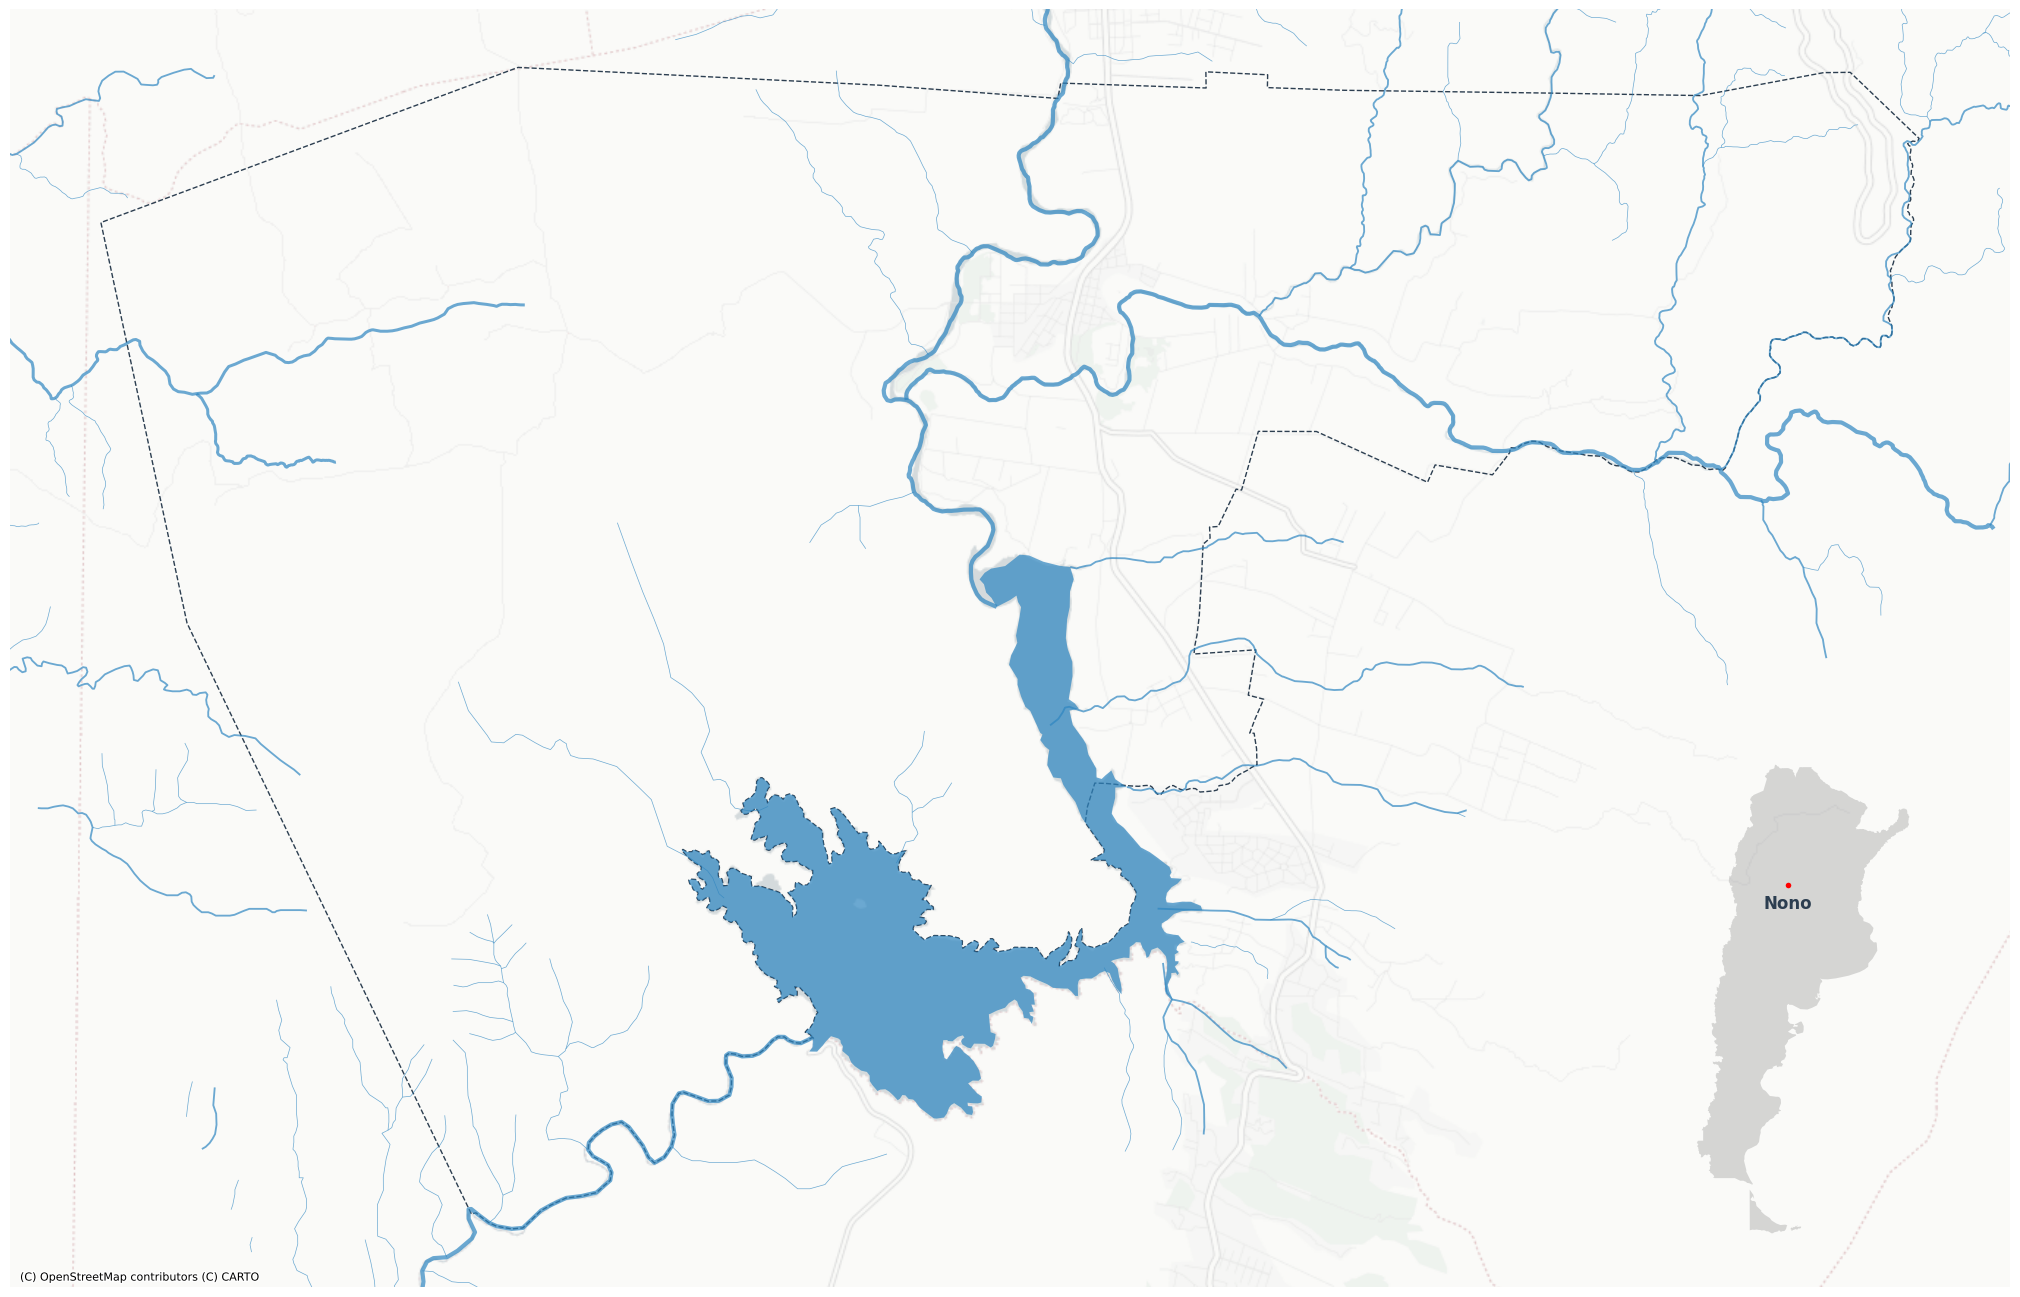

In [27]:
bounds = nono_3857.total_bounds
width = bounds[2] - bounds[0]
height = bounds[3] - bounds[1]
padding_x = width * 0.05  # add 5% padding
padding_y = height * 0.05

fig, ax = setup_base_map((20, 20), bounds, padding_x, padding_y)

add_basemap(ax)
add_water_features(ax)

add_nono_boundary(ax)

add_argentina_inset(ax)

ax.set_axis_off()
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

## JRC FLood

In [23]:
flood_depth_url = (
    "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/"
    "CEMS-GLOFAS/"
    "flood_hazard/"
    "RP100/"
    "ID74_S30_W70_RP100_depth.tif"
)
flood_depth = load_raster_data(flood_depth_url)

flood_depth_3857 = flood_depth.rio.reproject(
    dst_crs="EPSG:3857",
    resolution=100,  # 100m resolution
).rio.clip(nono_3857.geometry, from_disk=True)

In [24]:
def add_flood_layer(ax, flood_data, canvas_width=1500, canvas_height=1500):
    """Add flood depth raster to the map using datashader."""

    canvas = ds.Canvas(plot_width=canvas_width, plot_height=canvas_height)

    # Create mask for flood areas (where flood depth > 0)
    flood_mask = flood_data > 0

    # Rasterize the flood mask
    flood_agg = canvas.raster(flood_mask.sel(band=1))

    flood_agg.where(flood_agg > 0).plot.imshow(
        ax=ax,
        alpha=0.7,
        cmap="Blues",
        zorder=2,
        add_colorbar=False,
    )

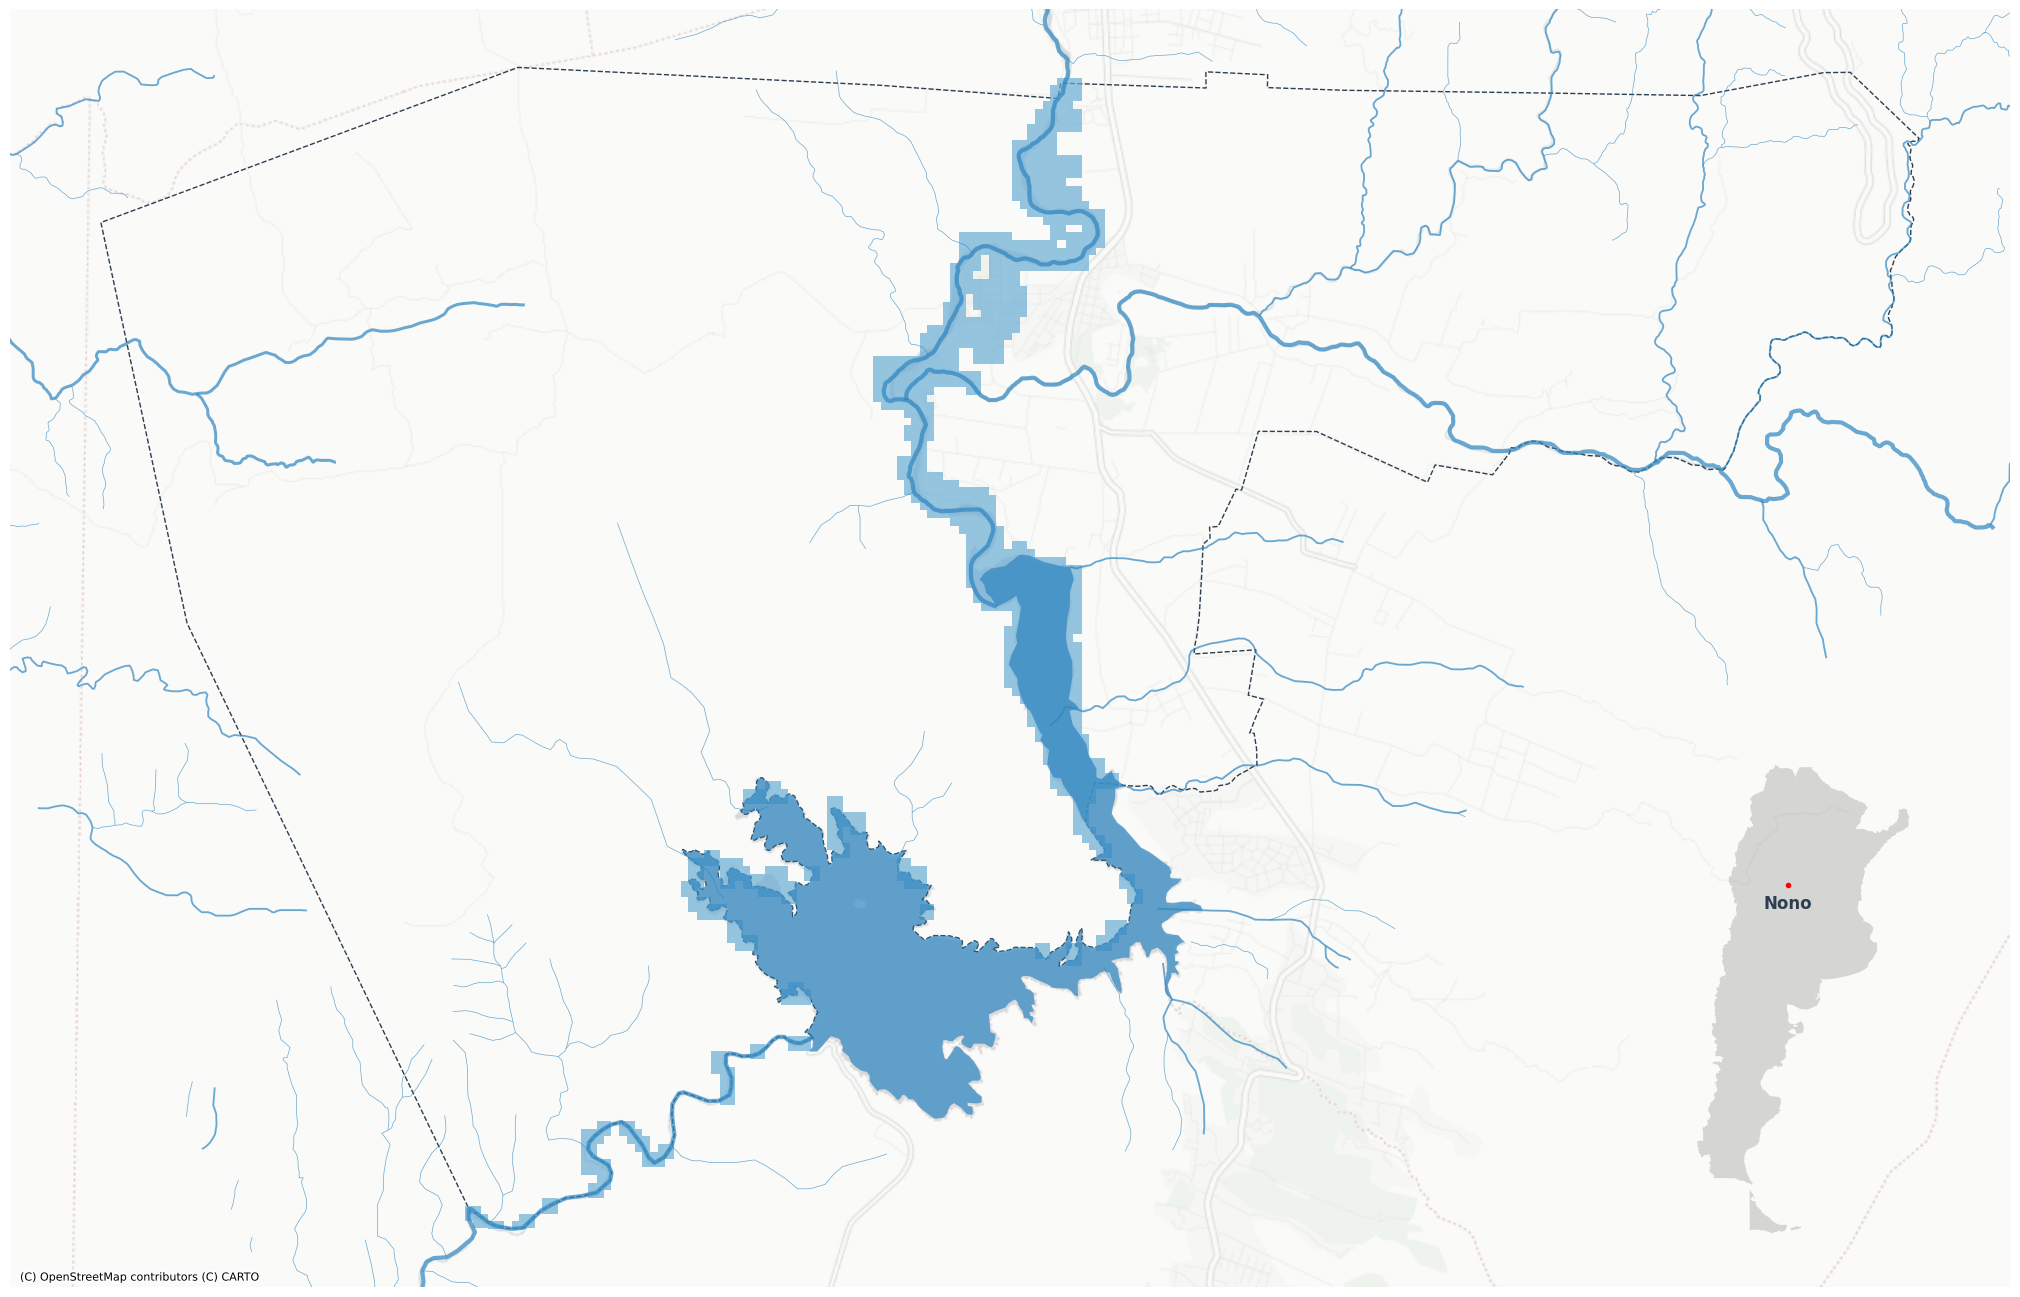

In [28]:
fig, ax = setup_base_map((20, 20), bounds, padding_x, padding_y)

add_basemap(ax)

add_flood_layer(ax, flood_depth_3857)

add_nono_boundary(ax)

add_water_features(ax)

add_argentina_inset(ax)

ax.set_axis_off()
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

## GHSL

In [29]:
ghsl_url = (
    "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/"
    "GHS_POP_GLOBE_R2023A/"
    "GHS_POP_E2025_GLOBE_R2023A_54009_100/"
    "V1-0/"
    "tiles/"
    "GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R13_C13.zip"
)
ghsl = load_raster_data(
    ghsl_url, "GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R13_C13.tif"
)

ghsl_3857 = ghsl.rio.reproject(
    dst_crs="EPSG:3857",
    resolution=100,
).rio.clip(nono_3857.geometry)

In [30]:
# Calculate centroid in Web Mercator first
center = nono_3857.geometry.centroid.iloc[0]

# Convert the centroid point to WGS84 for S2
center_wgs84 = gpd.GeoDataFrame(geometry=[center], crs="EPSG:3857").to_crs(epsg=4326)
center = center_wgs84.geometry.iloc[0]

# Get the S2 cell ID at level 10
cell = s2sphere.CellId.from_lat_lng(
    s2sphere.LatLng.from_degrees(center.y, center.x)
).parent(10)

# Configure S3 client for Source Cooperative
s3 = boto3.client(
    "s3",
    endpoint_url="https://data.source.coop",
    aws_access_key_id="",
    aws_secret_access_key="",
    config=Config(s3={"addressing_style": "path"}),
)

# List objects in the Argentina directory
response = s3.list_objects_v2(
    Bucket="vida",
    Prefix="google-microsoft-open-buildings/geoparquet/by_country_s2/country_iso=ARG/",
)

# Extract partition IDs from the keys
partitions = {
    obj["Key"].split("/")[-1].replace(".parquet", "")
    for obj in response.get("Contents", [])
}

# Check each level up to find a matching partition
for level in range(10, 0, -1):
    parent_id = str(cell.parent(level).id())

    if parent_id in partitions:
        break

# Initialize DuckDB connection
con = duckdb.connect()

# Install and load required extensions
con.execute("INSTALL spatial")
con.execute("LOAD spatial")

# Configure S3 settings
con.execute("SET s3_region='us-east-1'")
con.execute("SET s3_endpoint='data.source.coop'")
con.execute("SET s3_use_ssl=true")
con.execute("SET s3_url_style='path'")

# Convert Nono to WGS84 for spatial query
nono_wkt = nono_3857.to_crs(epsg=4326).geometry.iloc[0].wkt

# Now query with spatial filtering
query = f"""
SELECT 
    ST_AsText(geometry) as geometry_wkt,
    *
FROM read_parquet('s3://vida/google-microsoft-open-buildings/geoparquet/by_country_s2/country_iso=ARG/{parent_id}.parquet')
WHERE ST_Intersects(geometry, ST_GeomFromText('{nono_wkt}'))
"""
# query takes about 1.5 minutes to run
buildings = con.execute(query).df()

# Create GeoDataFrame using the WKT geometry column
buildings = gpd.GeoDataFrame(
    buildings,
    geometry=gpd.GeoSeries.from_wkt(buildings["geometry_wkt"]),
    crs="EPSG:4326",
)

buildings_3857 = buildings.to_crs(epsg=3857)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [44]:
def add_ghsl_layer(ax, ghsl_data, flood_mask, canvas_width=1500, canvas_height=1500):
    """Add GHSL population data to the map using datashader."""

    canvas = ds.Canvas(plot_width=canvas_width, plot_height=canvas_height)

    flood_agg = canvas.raster(flood_mask.sel(band=1))

    ghsl_agg = canvas.raster(ghsl_data.sel(band=1))

    masked_ghsl = ghsl_agg.where(flood_agg)
    masked_ghsl = masked_ghsl.where(masked_ghsl > 0)  # Only show areas with population

    masked_ghsl.plot.imshow(
        ax=ax,
        alpha=0.9,
        cmap="Reds",
        vmin=masked_ghsl.quantile(0.3),  # Start from 30th percentile to use darkest 70%
        vmax=masked_ghsl.max(),
        zorder=2,
        add_colorbar=False,
    )


def add_building_footprints(ax, buildings_data, color="#67000d", alpha=1.0):
    """Add building footprints to the map."""
    buildings_data.plot(
        ax=ax,
        color=color,
        zorder=2,
        alpha=alpha,
        edgecolor="none",
    )


def calculate_exposure_statistics(flood_gdf, ghsl_data, buildings_data, affine):
    """Calculate population and building exposure statistics."""

    stats = zonal_stats(
        flood_gdf.geometry.tolist(),
        ghsl_data.sel(band=1).values,
        stats=["sum"],
        nodata=-9999,
        affine=affine,
        all_touched=True,
    )
    population_in_flood = sum(stat["sum"] for stat in stats if stat["sum"] is not None)
    total_population = ghsl_data.sel(band=1).sum().item()
    population_percentage = (population_in_flood / total_population) * 100

    buildings_in_flood = gpd.sjoin(
        buildings_data, flood_gdf, how="inner", predicate="intersects"
    )
    # Remove duplicates that might occur from multiple intersections
    buildings_in_flood = buildings_in_flood.drop_duplicates(
        subset=buildings_in_flood.geometry.name
    )

    total_buildings = len(buildings_data)
    buildings_exposed = len(buildings_in_flood)
    buildings_percentage = (buildings_exposed / total_buildings) * 100

    # Calculate weighted centroid
    weighted_x = (
        buildings_in_flood.geometry.centroid.x * buildings_in_flood.geometry.area
    ).sum() / buildings_in_flood.geometry.area.sum()
    weighted_y = (
        buildings_in_flood.geometry.centroid.y * buildings_in_flood.geometry.area
    ).sum() / buildings_in_flood.geometry.area.sum()

    return {
        "population_in_flood": population_in_flood,
        "population_percentage": population_percentage,
        "buildings_exposed": buildings_exposed,
        "buildings_percentage": buildings_percentage,
        "buildings_in_flood": buildings_in_flood,
        "weighted_centroid": (weighted_x, weighted_y),
    }


def add_exposure_statistics(ax1, ax2, pop_stats, building_stats):
    """Add exposure statistics text to both axes."""
    population_in_flood, population_percentage = pop_stats
    buildings_exposed, buildings_percentage = building_stats

    ax1.text(
        0.98,
        0.02,
        f"Población expuesta: {population_in_flood:,.0f} ({population_percentage:.1f}%)",
        transform=ax1.transAxes,
        ha="right",
        va="bottom",
        fontsize=30,
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="none", pad=5),
        zorder=4,
    )

    ax2.text(
        0.98,
        0.02,
        f"Edificios expuestos: {buildings_exposed:,} ({buildings_percentage:.1f}%)",
        transform=ax2.transAxes,
        ha="right",
        va="bottom",
        fontsize=30,
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="none", pad=5),
        zorder=4,
    )

In [32]:
def create_flood_vector(flood_data):
    """Create vector representation of flood areas from raster data.

    Parameters
    ----------
    flood_data : xarray.DataArray
        Flood depth raster data

    Returns
    -------
    GeoDataFrame
        Vector representation of flood areas
    """
    # Create boolean mask and convert to uint8
    flood_mask = flood_data > 0
    mask_array = flood_mask.sel(band=1).values.astype("uint8")
    affine = flood_data.rio.transform()

    # Convert mask to polygons using rasterio.features.shapes
    shapes = features.shapes(
        mask_array,
        mask=mask_array,
        transform=affine,
        connectivity=8,  # Use 8-pixel connectivity for smoother boundaries
    )

    flood_gdf = gpd.GeoDataFrame(
        geometry=[shape(geom) for geom, val in shapes], crs=flood_data.rio.crs
    )

    return flood_gdf

In [33]:
def create_focus_area(weighted_x, weighted_y, size=2500):
    """Create a square focus area around weighted centroid."""
    square = gpd.GeoDataFrame(
        geometry=[
            box(
                weighted_x - size / 2,
                weighted_y - size / 2,
                weighted_x + size / 2,
                weighted_y + size / 2,
            )
        ],
        crs="EPSG:3857",
    )
    return square

In [34]:
# Create mask for flood areas (where flood depth > 0)
flood_mask = flood_depth_3857 > 0
mask_array = flood_mask.sel(band=1).values
affine = flood_depth_3857.rio.transform()

# Create flood vector using the function
flood_gdf = create_flood_vector(flood_depth_3857)

# Calculate all exposure statistics using the dedicated function
stats = calculate_exposure_statistics(
    flood_gdf=flood_gdf,
    ghsl_data=ghsl_3857,
    buildings_data=buildings_3857,
    affine=affine,
)

# Get all the stats we need
population_in_flood = stats["population_in_flood"]
population_percentage = stats["population_percentage"]
buildings_exposed = stats["buildings_exposed"]
buildings_percentage = stats["buildings_percentage"]
buildings_in_flood = stats["buildings_in_flood"]  # It's already calculated here!
weighted_x, weighted_y = stats["weighted_centroid"]

# Create focus area using the weighted centroid
focus_area = create_focus_area(weighted_x=weighted_x, weighted_y=weighted_y, size=2500)

In [35]:
def setup_dual_map(square_bounds, figsize):
    """Create figure with two subplots and set bounds."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    for ax in [ax1, ax2]:
        ax.set_xlim(square_bounds[0], square_bounds[2])
        ax.set_ylim(square_bounds[1], square_bounds[3])
    return fig, ax1, ax2


def add_location_inset(ax, weighted_x, weighted_y, nono_boundary):
    """Add inset map showing location within Nono."""
    axins = ax.inset_axes([0.02, 0.75, 0.3, 0.3])

    nono_boundary.plot(
        ax=axins,
        facecolor="grey",
        edgecolor="none",
        linewidth=0.8,
        alpha=0.3,
        zorder=3,
    )

    # Set inset bounds
    inset_bounds = nono_boundary.total_bounds
    inset_padding = (inset_bounds[2] - inset_bounds[0]) * 0.1
    axins.set_xlim(inset_bounds[0] - inset_padding, inset_bounds[2] + inset_padding)
    axins.set_ylim(inset_bounds[1] - inset_padding, inset_bounds[3] + inset_padding)

    # Add location marker
    axins.plot(
        weighted_x,
        weighted_y,
        marker="o",
        color="red",
        markersize=4,
        markeredgecolor="none",
        markeredgewidth=1,
        zorder=3,
    )

    axins.text(
        weighted_x,
        weighted_y - 1000,
        "Location",
        fontsize=12,
        ha="center",
        va="top",
        color="#2C3E50",
        fontweight="bold",
        bbox=dict(
            boxstyle="round,pad=0.2",
            facecolor="none",
            alpha=1.0,
            edgecolor="none",
        ),
        zorder=4,
    )

    axins.set_axis_off()


def add_population_layer(ax, masked_ghsl_data):
    """Add population exposure visualization."""
    masked_ghsl_data.plot.imshow(
        ax=ax,
        alpha=0.9,
        cmap="Reds",
        vmin=masked_ghsl_data.quantile(0.3),
        vmax=masked_ghsl_data.max(),
        zorder=2,
        add_colorbar=False,
    )


def add_buildings_layer(ax, buildings_data):
    """Add exposed buildings visualization."""
    buildings_data.plot(
        ax=ax,
        color="#67000d",
        zorder=2,
        alpha=1.0,
    )

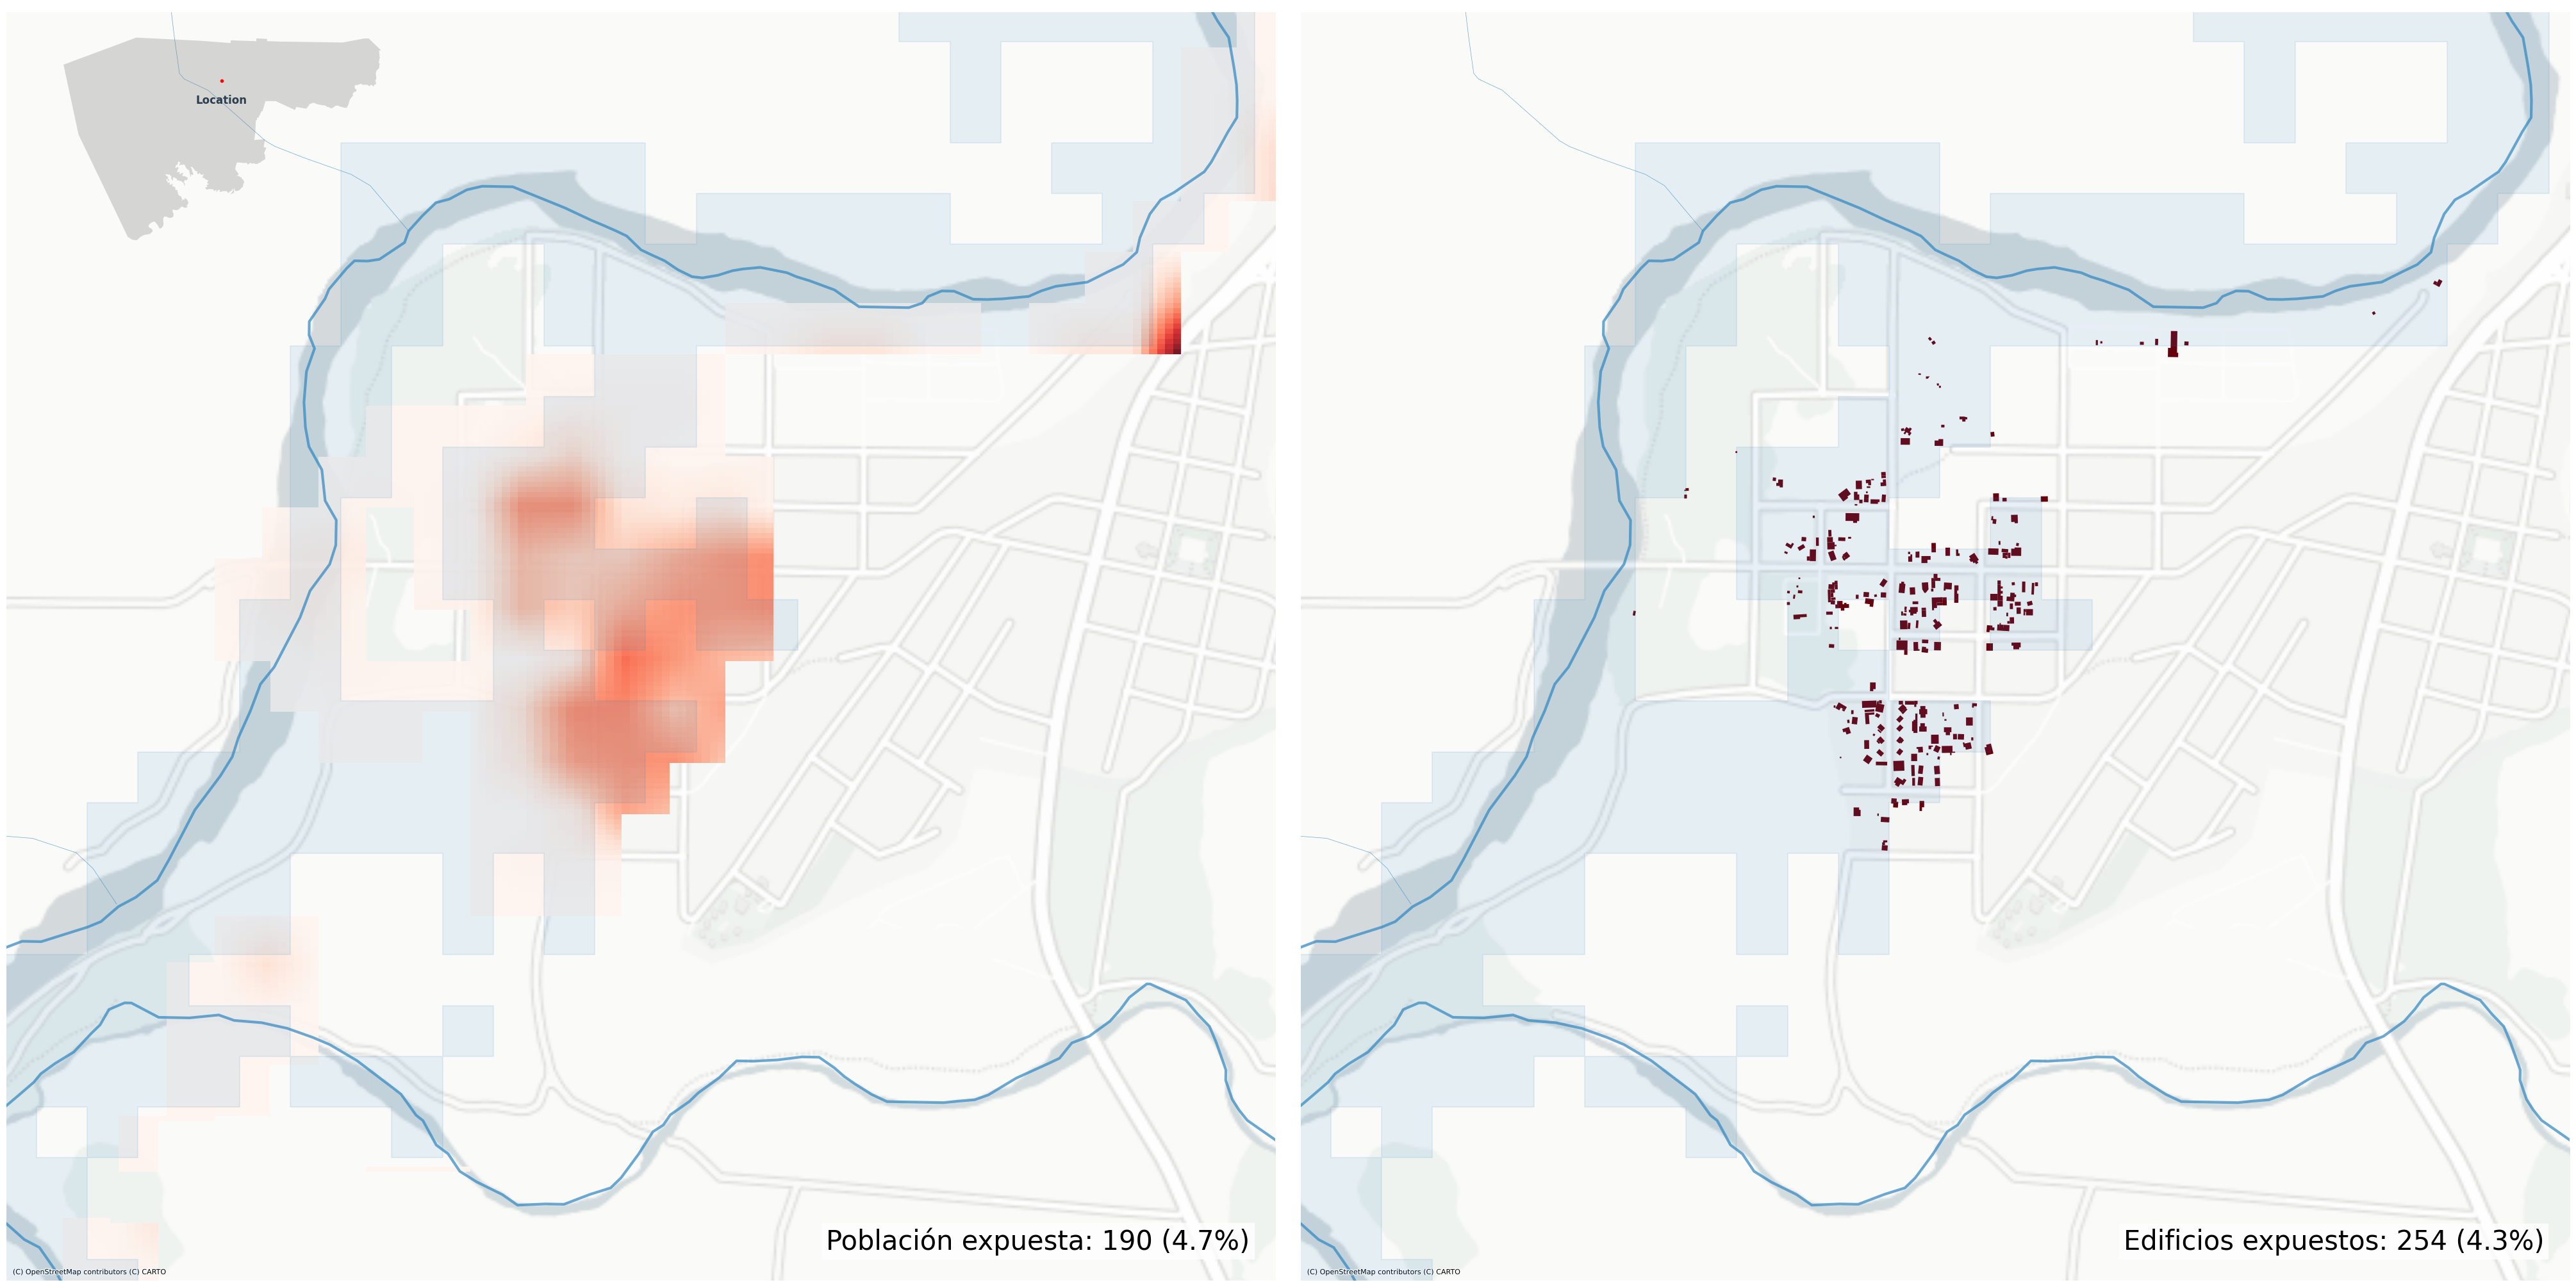

In [45]:
square_bounds = focus_area.total_bounds

# Setup dual map
fig, ax1, ax2 = setup_dual_map(square_bounds, (40, 20))

# Add location inset to first axis
add_location_inset(ax1, weighted_x, weighted_y, nono_3857)

# Create datashader canvas and process data (this stays the same)
canvas = ds.Canvas(plot_width=1500, plot_height=1500)
flood_agg = canvas.raster(flood_mask.sel(band=1))
ghsl_agg = canvas.raster(ghsl_3857.sel(band=1))
masked_ghsl = ghsl_agg.where(flood_agg).where(ghsl_agg > 0)


for ax in [ax1, ax2]:
    add_basemap(ax, zoom=15)

add_population_layer(ax1, masked_ghsl)

for ax in [ax1, ax2]:
    add_nono_boundary(ax)

    add_water_features(ax)
    flood_gdf.plot(
        ax=ax,
        facecolor="#2E86C1",
        edgecolor="#2E86C1",
        alpha=0.1,
        linewidth=1.5,
        zorder=3,
    )

add_buildings_layer(ax2, buildings_in_flood)

add_exposure_statistics(
    ax1,
    ax2,
    (population_in_flood, population_percentage),
    (buildings_exposed, buildings_percentage),
)

for ax in [ax1, ax2]:
    ax.set_axis_off()
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.02)
plt.show()

In [37]:
def load_all_return_periods(base_url, return_periods):
    """
    Load multiple return period flood depth rasters into a single xarray dataset.
    """
    datasets = []
    for i, rp in enumerate(return_periods, 1):
        url = base_url.replace("RP100", f"RP{rp}")

        flood_depth = rio.open_rasterio(url, masked=True)
        flood_depth_3857 = flood_depth.rio.reproject(
            dst_crs="EPSG:3857",
            resolution=100,
        )
        flood_depth_3857 = flood_depth_3857.rio.clip(nono_3857.geometry, from_disk=True)
        flood_depth_3857 = flood_depth_3857.expand_dims({"return_period": [rp]})
        datasets.append(flood_depth_3857)

    combined = xr.concat(datasets, dim="return_period")
    return combined


return_periods = [10, 20, 50, 75, 100, 200, 500]
base_url = "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/CEMS-GLOFAS/flood_hazard/RP100/ID74_S30_W70_RP100_depth.tif"

flood_depths = load_all_return_periods(base_url, return_periods)

In [38]:
exposure_results = []

for rp in flood_depths.return_period.values:
    flood_data = flood_depths.sel(return_period=rp)

    flood_gdf = create_flood_vector(flood_data)

    stats = calculate_exposure_statistics(
        flood_gdf=flood_gdf,
        ghsl_data=ghsl_3857,
        buildings_data=buildings_3857,
        affine=affine,
    )

    exposure_results.append(
        {
            "return_period": rp,
            "population_exposed": stats["population_in_flood"],
            "population_percentage": stats["population_percentage"],
            "buildings_exposed": stats["buildings_exposed"],
            "buildings_percentage": stats["buildings_percentage"],
        }
    )

exposure_df = pd.DataFrame(exposure_results)

# Convert return periods to annual probabilities
exposure_df["annual_probability"] = 1 / exposure_df["return_period"]

exposure_df = exposure_df.sort_values("annual_probability")

# fit exposure curves
x_fit = np.logspace(
    np.log10(exposure_df["annual_probability"].min()),
    np.log10(exposure_df["annual_probability"].max()),
    1000,
)

f_pop = interp1d(
    exposure_df["annual_probability"],
    exposure_df["population_exposed"],
    kind="cubic",
    bounds_error=False,
    fill_value=(
        exposure_df["population_exposed"].iloc[0],
        exposure_df["population_exposed"].iloc[-1],
    ),
)
y_fit_pop = f_pop(x_fit)

f_build = interp1d(
    exposure_df["annual_probability"],
    exposure_df["buildings_exposed"],
    kind="cubic",
    bounds_error=False,
    fill_value=(
        exposure_df["buildings_exposed"].iloc[0],
        exposure_df["buildings_exposed"].iloc[-1],
    ),
)
y_fit_build = f_build(x_fit)


def calculate_expected_annual_impact_smooth(prob_array, exposure_function):
    """
    Calculate expected annual impact using smooth interpolated curve.

    Parameters:
    prob_array: array of probability values
    exposure_function: interpolation function that gives exposure for given probability
    """
    # Integrate the interpolated function
    expected_impact, _ = integrate.quad(
        exposure_function, prob_array.min(), prob_array.max()
    )
    return expected_impact


expected_pop = calculate_expected_annual_impact_smooth(x_fit, f_pop)
expected_buildings = calculate_expected_annual_impact_smooth(x_fit, f_build)

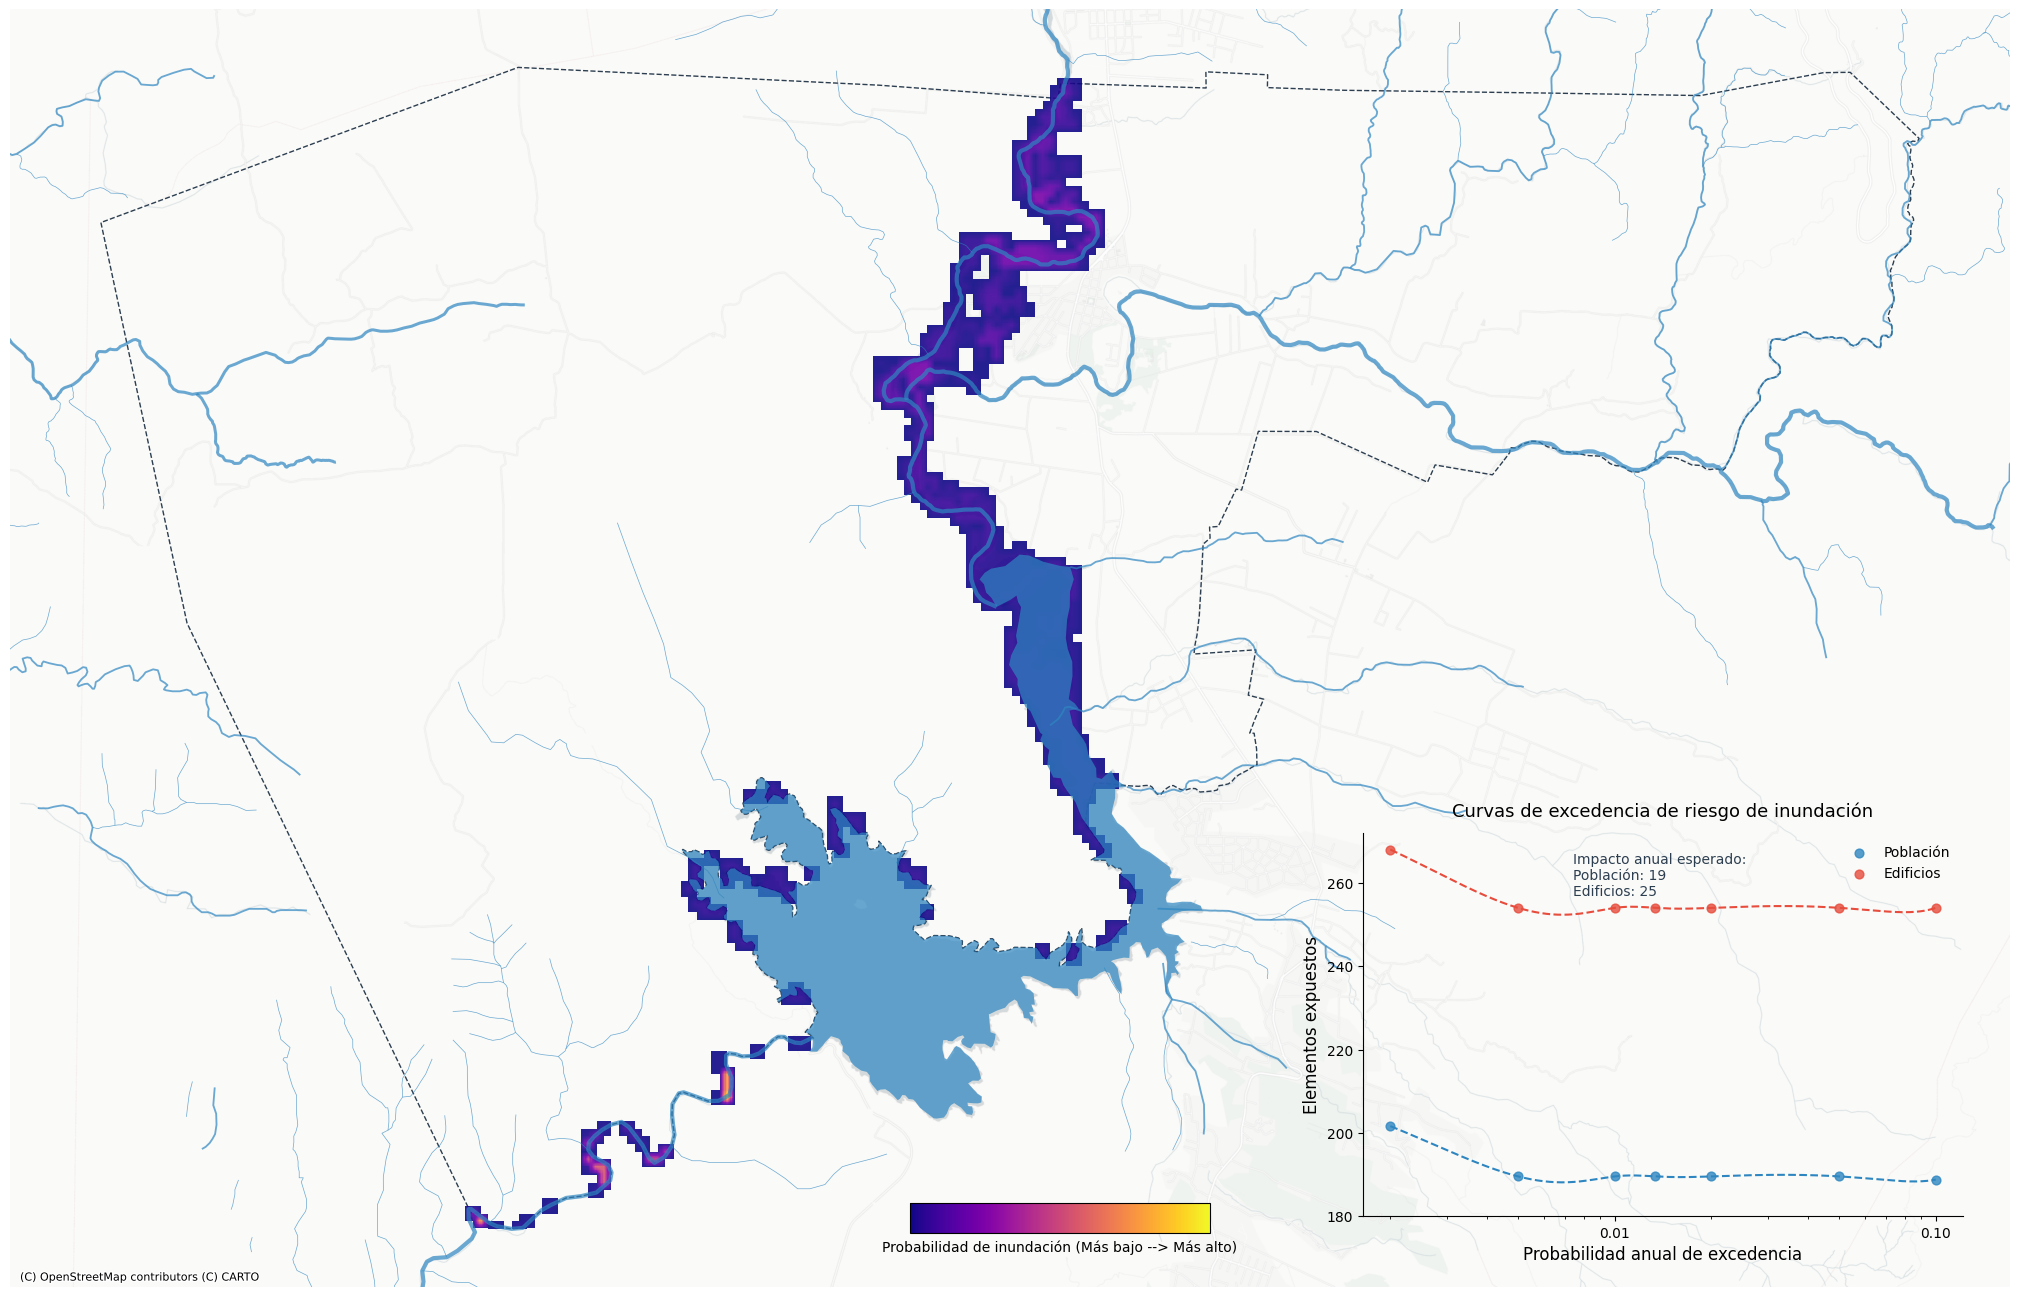

In [43]:
fig, ax1 = plt.subplots(1, 1, figsize=(20, 15))

# Set the plot limits to match the Nono boundary for the map
bounds = nono_3857.total_bounds
width = bounds[2] - bounds[0]
height = bounds[3] - bounds[1]
padding_x = width * 0.05
padding_y = height * 0.05
ax1.set_xlim(bounds[0] - padding_x, bounds[2] + padding_x)
ax1.set_ylim(bounds[1] - padding_y, bounds[3] + padding_y)


canvas = ds.Canvas(plot_width=1500, plot_height=1500)

# Sum flood depths across return periods
flood_sum = flood_depths.sum(dim="return_period")

# Rasterize the summed flood data
flood_agg = canvas.raster(flood_sum.sel(band=1))

add_basemap(ax1, zoom=15)

# Plot the summed flood data
flood_agg.where(flood_agg > 0).plot.imshow(
    ax=ax1, cmap="plasma", zorder=2, add_colorbar=False, alpha=0.9
)

add_water_features(ax1)

add_nono_boundary(ax1)

# Create inset for exceedance curve using inset_axes
axins = inset_axes(
    ax1,
    width="30%",
    height="30%",
    loc="lower right",
    bbox_to_anchor=(-0.02, 0.05, 1, 1),
    bbox_transform=ax1.transAxes,
)

# Plot both population and buildings data points
axins.scatter(
    exposure_df["annual_probability"],
    exposure_df["population_exposed"],
    color="#2E86C1",  # Blue for population
    s=40,
    alpha=0.8,
    label="Población",
)

axins.scatter(
    exposure_df["annual_probability"],
    exposure_df["buildings_exposed"],
    color="#E74C3C",  # Red for buildings
    s=40,
    alpha=0.8,
    label="Edificios",
)

# Plot the fitted curves
axins.plot(
    x_fit,
    f_pop(x_fit),
    color="#2E86C1",
    linewidth=1.5,
    linestyle="--",
    label="_nolegend_",
)
axins.plot(
    x_fit,
    f_build(x_fit),
    color="#E74C3C",
    linewidth=1.5,
    linestyle="--",
    label="_nolegend_",
)

axins.set_xlabel("Probabilidad anual de excedencia", fontsize=12)
axins.set_ylabel("Elementos expuestos", fontsize=12)
axins.set_title("Curvas de excedencia de riesgo de inundación", fontsize=13, pad=12)


axins.set_xscale("log")
axins.set_ylim(bottom=180)
axins.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.2f}"))

axins.legend(fontsize=10, frameon=False)

axins.text(
    0.35,
    0.95,
    f"Impacto anual esperado:\nPoblación: {expected_pop:,.0f}\nEdificios: {expected_buildings:,.0f}",
    transform=axins.transAxes,
    verticalalignment="top",
    fontsize=10,
    color="#2C3E50",
)

axins.grid(False)
axins.spines["top"].set_visible(False)
axins.spines["right"].set_visible(False)
axins.spines["left"].set_visible(True)
axins.spines["bottom"].set_visible(True)
axins.tick_params(axis="both", which="major", labelsize=10)

axins.patch.set_facecolor("none")
axins.patch.set_zorder(0)

ax1.set_axis_off()

# Get the maximum flood depth value for the colorbar normalization
max_flood_depth = flood_agg.max().item()

# Create a colormap and normalization object for the colorbar
cmap = plt.colormaps["plasma"]  # Updated syntax
norm = mcolors.Normalize(vmin=0, vmax=max_flood_depth)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Create a new axes for the colorbar at the bottom of the figure
cbar_ax = fig.add_axes([0.45, 0.11, 0.15, 0.02])

# Create the colorbar using the ScalarMappable and the dedicated axes
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")

cbar.set_ticks([])
cbar.set_ticklabels([])

# Set the label for the colorbar
cbar.set_label(
    "Probabilidad de inundación (Más bajo --> Más alto)",
    fontsize=10,
    ha="center",
    labelpad=5,
)

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()